# Software Requirements Classification
## Logistic Regression and data anylysis

### Data Preprocessing

In [231]:
import pandas as pd

df = pd.read_csv('software_requirements_extended.csv')
df.head()

,Type,Requirement
0,PE,The system shall refresh the display every 60 ...
1,LF,The application shall match the color of the s...
2,US,If projected the data must be readable. On ...
3,A,The product shall be available during normal ...
4,US,If projected the data must be understandable...


In [232]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 977 entries, 0 to 976
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Type         977 non-null    object
 1   Requirement  977 non-null    object
dtypes: object(2)
memory usage: 15.4+ KB


In [233]:
import plotly.express as px

# draw a pie chart of the different sentiments of the posts
fig = px.pie(df, names='Type', title ='Pie of types of requirements')
fig.show()

data set is small and not balanced to write a model to predict all the types of requirements. but its enough and balanced to predict if type is functional or non-functional

In [234]:
df['Type'] = df['Type'].apply(lambda x: 1 if x == 'FR' or x == 'F' else 0)
fig = px.pie(df, names='Type', title ='Pie of types of requirements')
fig.show()

In [235]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Function to preprocess text and generate word cloud
def generate_wordcloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()


Word Cloud for Functional Requirements


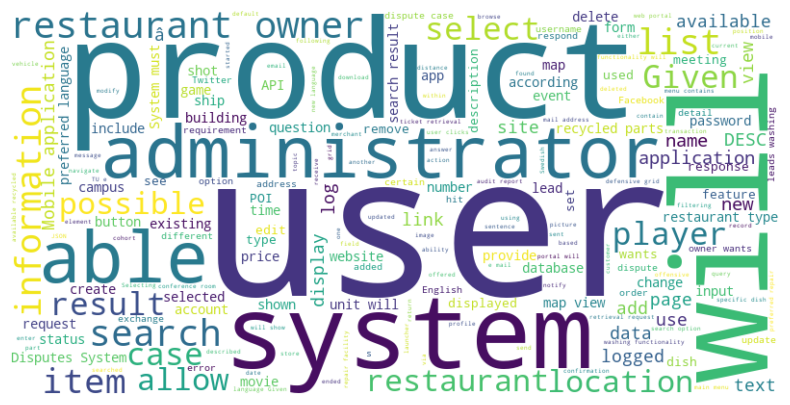

Word Cloud for Non-Functional Requirements


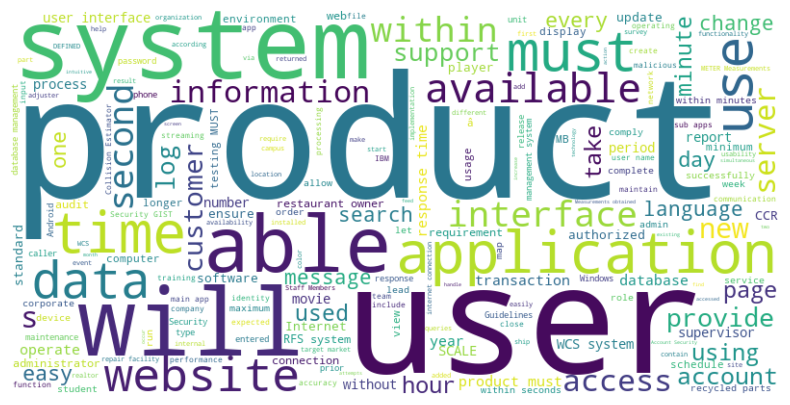

In [236]:
# Separate the requirements by type
functional_requirements = ' '.join(df[df['Type'] == 1]['Requirement'])
non_functional_requirements = ' '.join(df[df['Type'] == 0]['Requirement'])

# Generate and display word clouds
print("Word Cloud for Functional Requirements")
generate_wordcloud(functional_requirements)

print("Word Cloud for Non-Functional Requirements")
generate_wordcloud(non_functional_requirements)


here we can see that we have some noise words that we need to remove

In [237]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nickbres/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/nickbres/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

Create function that will get some text and 'clean' it and return list of words. Will try to use lemmatization or stemming and see which one is better with specific model. Also will try to delete stop words to see if it will improve the model.

In [238]:
# Pre-load stopwords to improve efficiency
STOPWORDS = set(stopwords.words("english"))

# Expanded pattern to potentially keep useful punctuation or additional cleaning
pattern_without_numbers = re.compile(r"[^a-zA-Z]")
pattern_with_numbers = re.compile(r"[^\w\d]")

def req_to_words(req, lemmatize, delete_stopwords, with_numbers, normalize_numbers):
    """Convert requirement text into a sequence of 'clean' words"""
    # Convert to lower case
    text = req.lower()
    
    if with_numbers:
        pattern = pattern_with_numbers
    else:
        pattern = pattern_without_numbers
    
    if normalize_numbers:
        text = re.sub(r'\b\d+\b', 'num', text)
    
    # Remove unwanted characters
    text = re.sub(pattern, " ", text)
    
    # Tokenize
    words = text.split()
    
    # Remove stopwords
    if delete_stopwords:
        words = [w for w in words if w not in STOPWORDS]

    # Apply lemmatization or stemming
    if lemmatize:
        words = [ WordNetLemmatizer().lemmatize(w) for w in words]
    else: # Stemming
        words = [PorterStemmer().stem(w) for w in words]
        
    # join the words back into one string
    clean_req = " ".join(words)
        
    return clean_req

# Example use
print("\nOriginal requirement ->", df['Requirement'][0])
print("\nLemmatization, no stopwords, no numbers ->", req_to_words(df['Requirement'][0],lemmatize=True, delete_stopwords=True, with_numbers=False, normalize_numbers=False))
print("\nStemming, no stopwords, no numbers ->", req_to_words(df['Requirement'][0],lemmatize=False, delete_stopwords=True, with_numbers=False, normalize_numbers=False))
print("\nLemmatization, no stopwords, with numbers ->", req_to_words(df['Requirement'][0],lemmatize=True, delete_stopwords=True, with_numbers=True, normalize_numbers=False))
print("\nLemmatization, no stopwords, with normalized numbers ->", req_to_words(df['Requirement'][0],lemmatize=True, delete_stopwords=True, with_numbers=True, normalize_numbers=True))
print("\nStemming, no stopwords, with numbers ->", req_to_words(df['Requirement'][0],lemmatize=False, delete_stopwords=True, with_numbers=True, normalize_numbers=False))
print("\nStemming, no stopwords, with normalized numbers ->", req_to_words(df['Requirement'][0],lemmatize=False, delete_stopwords=True, with_numbers=True, normalize_numbers=True))
print("\nLemmatization, with stopwords, no numbers ->", req_to_words(df['Requirement'][0],lemmatize=True, delete_stopwords=False, with_numbers=False, normalize_numbers=False))
print("\nStemming, with stopwords, no numbers ->", req_to_words(df['Requirement'][0],lemmatize=False, delete_stopwords=False, with_numbers=False, normalize_numbers=False))



Original requirement -> The system shall refresh the display every 60 seconds.

Lemmatization, no stopwords, no numbers -> system shall refresh display every second

Stemming, no stopwords, no numbers -> system shall refresh display everi second

Lemmatization, no stopwords, with numbers -> system shall refresh display every 60 second

Lemmatization, no stopwords, with normalized numbers -> system shall refresh display every num second

Stemming, no stopwords, with numbers -> system shall refresh display everi 60 second

Stemming, no stopwords, with normalized numbers -> system shall refresh display everi num second

Lemmatization, with stopwords, no numbers -> the system shall refresh the display every second

Stemming, with stopwords, no numbers -> the system shall refresh the display everi second


In [239]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression

### Model

In [240]:
import warnings
from sklearn.model_selection import GridSearchCV

def find_best_hyperparameters(X,y):
    # suppress warnings
    warnings.filterwarnings('ignore')
    with warnings.catch_warnings():
        # Ignore specific warnings
        warnings.simplefilter("ignore", UserWarning)
        warnings.simplefilter("ignore", FutureWarning)
    
    # looking for the best hyperparameters
    # Define the model
    model = LogisticRegression()

    # Define a grid of hyperparameters to search
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],  # Values for C
        'penalty': ['l1', 'l2', 'elasticnet', 'none'],  # Types of penalty
        'solver': ['liblinear', 'lbfgs', 'saga'],  # Solvers
        'max_iter': [100, 200, 300]  # Maximum iterations
    }
    
    # Setup the grid search
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
    
    # Fit the grid search to the data
    grid_search.fit(X, y)
    
    # Print the best parameters and the best score
    print("Best parameters:", grid_search.best_params_)
    print("Best score:", grid_search.best_score_)
    return grid_search.best_params_

In [241]:
import matplotlib.pyplot as plt

def draw_important_features(model, vectorizer):
    # Get the coefficients 
    feature_importances = model.coef_[0]
    
    # Get the feature names from the vectorizer
    feature_names = vectorizer.get_feature_names_out()
    
    # Zip feature importances with names and create a DataFrame
    importance_df = pd.DataFrame(list(zip(feature_names, feature_importances)), columns=['Feature', 'Importance'])
    
    # Sort the DataFrame by the absolute values of the Importance column
    importance_df = importance_df.reindex(importance_df.Importance.abs().sort_values(ascending=False).index)
    
    # Plot the top 20 features
    plt.figure(figsize=(10, 8))
    plt.barh(importance_df['Feature'][:30], importance_df['Importance'][:30])
    plt.gca().invert_yaxis()  # Invert the y-axis to show the most important feature at the top
    plt.xlabel('Coefficient Value')
    plt.title('Top 30 Features')
    plt.show()

In [242]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def draw_confusion_matrix(y_test, y_pred):
    # Compute the normalized confusion matrix
    cm_normalized = confusion_matrix(y_test, y_pred, normalize='true')
    
    # Convert to percentage
    cm_percentage = cm_normalized * 100
    
    # Visualize the confusion matrix as percentages
    plt.figure(figsize=(10,7))
    sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=['Non-Functional', 'Functional'], yticklabels=['Non-Functional', 'Functional'])
    plt.title('Confusion Matrix (Percentage)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [243]:
def run_experiment(df, preprocessing_params, ngram_range):
    """
    Run an experiment to train a logistic regression model with the best hyperparameters found using grid search.
    Evaluates the model using cross-validation and on a test set, and displays the model's important features and confusion matrix.

    Parameters:
    - df: DataFrame containing the dataset.
    - preprocessing_params: Dictionary containing preprocessing parameters (lemmatize, delete_stopwords, normalize_numbers, etc.).
    - ngram_range: Tuple indicating the range of n-grams to be used in vectorization.
    """
    # Extract preprocessing parameters
    lemmatize = preprocessing_params.get('lemmatize', True)
    delete_stopwords = preprocessing_params.get('delete_stopwords', True)
    with_numbers = preprocessing_params.get('with_numbers', True)
    normalize_numbers = preprocessing_params.get('normalize_numbers', True)

    # Prepare the data
    y = df['Type']
    # Preprocess the requirements to convert them into 'clean' words
    X = [req_to_words(req, lemmatize=lemmatize, delete_stopwords=delete_stopwords, with_numbers=with_numbers, normalize_numbers=normalize_numbers) for req in df['Requirement']]


    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Vectorize the text
    vectorizer = TfidfVectorizer(ngram_range=ngram_range)
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)

    # Find the best model parameters
    best_params = find_best_hyperparameters(X_train, y_train)
    
    # Create the best estimator
    best_estimator = LogisticRegression(**best_params)

    # Train the best estimator on the full training set
    best_estimator.fit(X_train, y_train)

    # Evaluate on the test set
    y_pred = best_estimator.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy * 100:.2f}%')

    # Detailed performance report
    print(classification_report(y_test, y_pred))

    # Additional evaluations
    draw_important_features(best_estimator, vectorizer)
    draw_confusion_matrix(y_test, y_pred)

    return best_estimator, vectorizer

### Experimenting

Fitting 5 folds for each of 180 candidates, totalling 900 fits


/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/nickbres/anaconda3/envs/S

Best parameters: {'C': 100, 'max_iter': 300, 'penalty': 'none', 'solver': 'saga'}
Best score: 0.8873121511378272
Accuracy: 88.10%
              precision    recall  f1-score   support

           0       0.87      0.90      0.89       131
           1       0.92      0.90      0.91       163

    accuracy                           0.90       294
   macro avg       0.90      0.90      0.90       294
weighted avg       0.90      0.90      0.90       294


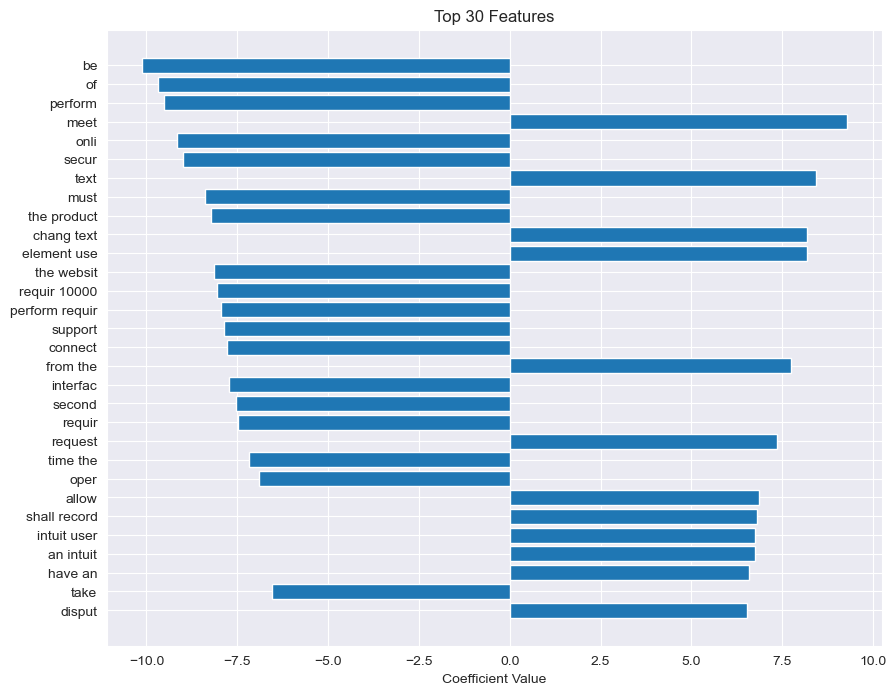

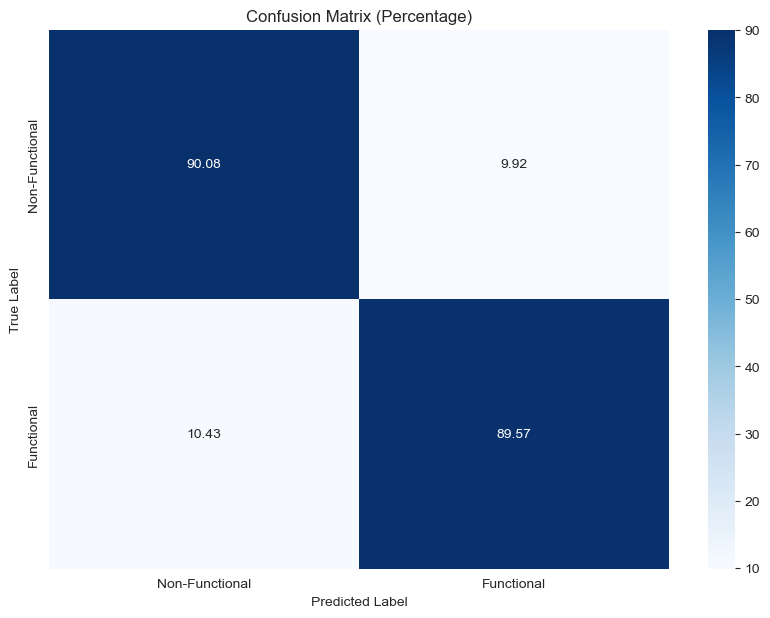

In [244]:
preprocessing_params = {
    'lemmatize': False,
    'delete_stopwords': False,
    'with_numbers': True,
    'normalize_numbers': False
}
ngram_range = (1, 2)
model, vectorizer = run_experiment(df, preprocessing_params, ngram_range)


### Manually testing the model
Using my own examples to see how the model performs on them instead of using the test set

In [245]:
def predict_req(req, expected, model, vectorizer, preprocessing_params):
    df = pd.DataFrame([req], columns=['Requirement'])
    
    lemmatize = preprocessing_params.get('lemmatize', True)
    delete_stopwords = preprocessing_params.get('delete_stopwords', True)
    with_numbers = preprocessing_params.get('with_numbers', True)
    normalize_numbers = preprocessing_params.get('normalize_numbers', True)

    X = [req_to_words(req, lemmatize=lemmatize, delete_stopwords=delete_stopwords, with_numbers=with_numbers, normalize_numbers=normalize_numbers) for req in df['Requirement']]
    X = vectorizer.transform(X)

    prediction = model.predict(X)
    predicted_label = 'Functional' if prediction[0] == 1 else 'Non-Functional'
    success = predicted_label == expected

    return predicted_label, success


In [246]:
def summarize_predictions(examples, model, vectorizer , preprocessing_params):
    results = []
    for req, expected_label in examples:
        predicted_label, success = predict_req(req, expected_label, model, vectorizer, preprocessing_params)
        results.append({
            'Requirement': req,
            'Expected Label': expected_label,
            'Predicted Label': predicted_label,
            'Success': success
        })
    return pd.DataFrame(results)

In [247]:
examples = [
    ("The system shall provide a login form that accepts a username and password.", 'Functional'),
    ("The application must ensure that response times are less than 2 seconds under normal load conditions.", 'Non-Functional'),
    ("All user passwords shall be encrypted before saving to the database.", 'Functional'),
    ("The software should be compatible with the Windows 10 operating system.", 'Non-Functional'),
    ("The interface shall refresh when new data is available.", 'Functional'),
    ("The product shall comply with international accessibility standards.", 'Non-Functional'),
    ("Database backup shall occur every 24 hours automatically.", 'Functional'),
    ("The system shall support a minimum of 500 concurrent user connections.", 'Functional'),
    ("The system’s mean time to failure shall be at least 10,000 hours.", 'Non-Functional'),
    ("Users must be able to complete the primary workflow in less than three minutes.", 'Non-Functional'),
    ("User settings must be retained for at least one year without login.", 'Non-Functional'),
    ("The system must support multi-language interfaces.", 'Functional'),
    ("Ensure data integrity during transaction processing.", 'Functional'),
    ("The application should load the user dashboard within 3 seconds.", 'Non-Functional'),
    ("Support data export to CSV and PDF formats.", 'Functional'),
    ("Must be compatible with both iOS and Android operating systems.", 'Non-Functional'),
    ("Implement two-factor authentication for user logins.", 'Functional'),
    ("The application must be available 99.9% of the time.", 'Non-Functional'),
    ("Automatically log out users after 30 minutes of inactivity.", 'Functional'),
    ("The system must scale to support up to 10,000 users simultaneously.", 'Non-Functional'),
    ("Provide a way to recover forgotten passwords securely.", 'Functional'),
    ("The system must encrypt sensitive data both at rest and in transit.", 'Non-Functional'),
    ("Support for user roles including admin, editor, and viewer.", 'Functional'),
    ("Ensure the application interface adheres to the latest web accessibility guidelines.", 'Non-Functional'),
    ("The software must be installable on both Windows and MacOS.", 'Non-Functional'),
    ("Offer a search function that returns results within 2 seconds.", 'Functional'),
    ("The mobile app should use no more than 50MB of data per hour of activity.", 'Non-Functional'),
    ("The platform must integrate seamlessly with third-party email services.", 'Functional'),
    ("User feedback must be addressed and incorporated within two release cycles.", 'Non-Functional'),
    ("Provide detailed logging of user actions to support auditing requirements.", 'Functional')
]


In [248]:
summary = summarize_predictions(examples, model, vectorizer, preprocessing_params)
summary

,Requirement,Expected Label,Predicted Label,Success
0,The system shall provide a login form that acc...,Functional,Functional,True
1,The application must ensure that response time...,Non-Functional,Non-Functional,True
2,All user passwords shall be encrypted before s...,Functional,Non-Functional,False
3,The software should be compatible with the Win...,Non-Functional,Non-Functional,True
4,The interface shall refresh when new data is a...,Functional,Non-Functional,False
5,The product shall comply with international ac...,Non-Functional,Non-Functional,True
6,Database backup shall occur every 24 hours aut...,Functional,Non-Functional,False
7,The system shall support a minimum of 500 conc...,Functional,Non-Functional,False
8,The system’s mean time to failure shall be at ...,Non-Functional,Non-Functional,True
9,Users must be able to complete the primary wor...,Non-Functional,Non-Functional,True


In [249]:
fig = px.pie(summary, names='Success', title ='Success of the model on my examples')
fig.show()